In [1]:
import sys,os
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path

import gym
import torch
import numpy as np
import datetime

from HierarchicalDQN.agent import HierarchicalDQN
from common.plot import plot_rewards
from common.utils import save_results

In [2]:
SEQUENCE = datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")  # obtain current time
SAVED_MODEL_PATH = curr_path+"/saved_model/"+SEQUENCE+'/'  # path to save model
if not os.path.exists(curr_path+"/saved_model/"):
    os.mkdir(curr_path+"/saved_model/")
if not os.path.exists(SAVED_MODEL_PATH):
    os.mkdir(SAVED_MODEL_PATH)
RESULT_PATH = curr_path+"/results/"+SEQUENCE+'/'  # path to save rewards
if not os.path.exists(curr_path+"/results/"):
    os.mkdir(curr_path+"/results/")
if not os.path.exists(RESULT_PATH):
    os.mkdir(RESULT_PATH)

In [3]:
class HierarchicalDQNConfig:
    def __init__(self):
        self.algo = "H-DQN"  # name of algo
        self.gamma = 0.95
        self.epsilon_start = 1  # start epsilon of e-greedy policy
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001  # learning rate
        self.memory_capacity = 20000  # Replay Memory capacity
        self.batch_size = 64
        self.train_eps = 300  # 训练的episode数目
        self.target_update = 2  # target net的更新频率
        self.eval_eps = 20  # 测试的episode数目
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # 检测gpu
        self.hidden_dim = 256  # dimension of hidden layer

In [4]:
def train(cfg, env, agent):
    print('Start to train !')
    rewards = []
    ma_rewards = []  # moveing average reward
    for i_episode in range(cfg.train_eps):
        state = env.reset()
        done = False
        ep_reward = 0
        while not done:
            goal = agent.set_goal(state)
            onehot_goal = agent.to_onehot(goal)
            meta_state = state
            extrinsic_reward = 0
            while not done and goal != np.argmax(state):
                goal_state = np.concatenate([state, onehot_goal])
                action = agent.choose_action(goal_state)
                next_state, reward, done, _ = env.step(action)
                ep_reward += reward
                extrinsic_reward += reward
                intrinsic_reward = 1.0 if goal == np.argmax(
                    next_state) else 0.0
                agent.memory.push(goal_state, action, intrinsic_reward, np.concatenate(
                    [next_state, onehot_goal]), done)
                state = next_state
                agent.update()
        agent.meta_memory.push(meta_state, goal, extrinsic_reward, state, done)
        print('Episode:{}/{}, Reward:{}'.format(i_episode+1, cfg.train_eps, ep_reward))
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('Complete training！')
    return rewards, ma_rewards

Start to train !
Episode:1/300, Reward:20.0
Episode:2/300, Reward:17.0
Episode:3/300, Reward:14.0
Episode:4/300, Reward:40.0
Episode:5/300, Reward:32.0
Episode:6/300, Reward:41.0
Episode:7/300, Reward:12.0
Episode:8/300, Reward:17.0
Episode:9/300, Reward:19.0
Episode:10/300, Reward:13.0
Episode:11/300, Reward:11.0
Episode:12/300, Reward:18.0
Episode:13/300, Reward:28.0
Episode:14/300, Reward:26.0
Episode:15/300, Reward:76.0
Episode:16/300, Reward:53.0
Episode:17/300, Reward:60.0
Episode:18/300, Reward:49.0
Episode:19/300, Reward:58.0
Episode:20/300, Reward:21.0
Episode:21/300, Reward:53.0
Episode:22/300, Reward:25.0
Episode:23/300, Reward:200.0
Episode:24/300, Reward:200.0
Episode:25/300, Reward:61.0
Episode:26/300, Reward:156.0
Episode:27/300, Reward:126.0
Episode:28/300, Reward:124.0
Episode:29/300, Reward:47.0
Episode:30/300, Reward:142.0
Episode:31/300, Reward:145.0
Episode:32/300, Reward:51.0
Episode:33/300, Reward:95.0
Episode:34/300, Reward:109.0
Episode:35/300, Reward:71.0
Epis

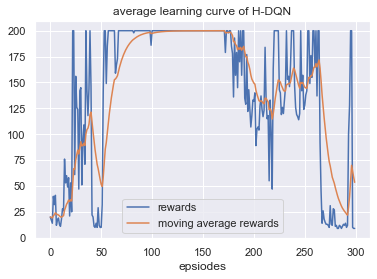

In [5]:
env = gym.make('CartPole-v0')
env.seed(1)
cfg = HierarchicalDQNConfig()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = HierarchicalDQN(state_dim, action_dim, cfg)
rewards, ma_rewards = train(cfg, env, agent)
agent.save(path=SAVED_MODEL_PATH)
save_results(rewards, ma_rewards, tag='train', path=RESULT_PATH)
plot_rewards(rewards, ma_rewards, tag="train",
                algo=cfg.algo, path=RESULT_PATH)